In [1]:
from rnamodif.data_utils.dataloading import get_test_dataset
from rnamodif.data_utils.datamap import experiment_files
import torch
from rnamodif.evaluation.evaluation import run_test
from rnamodif.architectures.rodan_pretrained_MIL import RodanPretrainedMIL


def get_dsets_preds(checkpoint):
    workers=8
    architecture=RodanPretrainedMIL
    window=4096

    test_dset_covid0 = get_test_dataset(experiment_files['m6A_0_covid'], window=window, normalization='rodan', trim_primer=False)
    predictions_covid0 = run_test(test_dset_covid0,checkpoint=checkpoint, workers=workers, architecture=architecture)

    test_dset_covid5 = get_test_dataset(experiment_files['m6A_5_covid'], window=window, normalization='rodan', trim_primer=False)
    predictions_covid5 = run_test(test_dset_covid5,checkpoint=checkpoint, workers=workers, architecture=architecture)

    test_dset_covid10 = get_test_dataset(experiment_files['m6A_10_covid'], window=window, normalization='rodan', trim_primer=False)
    predictions_covid10 = run_test(test_dset_covid10,checkpoint=checkpoint, workers=workers, architecture=architecture)

    test_dset_covid33 = get_test_dataset(experiment_files['m6A_33_covid'], window=window, normalization='rodan', trim_primer=False)
    predictions_covid33 = run_test(test_dset_covid33,checkpoint=checkpoint, workers=workers, architecture=architecture)

    test_dset_novoa_1 = get_test_dataset(experiment_files['m6a_novoa_1'], window=window, normalization='rodan', trim_primer=False)
    predictions_novoa_1 = run_test(test_dset_novoa_1,checkpoint=checkpoint, workers=workers, architecture=architecture)

    test_dset_novoa_2 = get_test_dataset(experiment_files['m6a_novoa_2'], window=window, normalization='rodan', trim_primer=False)
    predictions_novoa_2 = run_test(test_dset_novoa_2,checkpoint=checkpoint, workers=workers, architecture=architecture)

    test_dset_unm_1 = get_test_dataset(experiment_files['UNM_novoa_1'], window=window, normalization='rodan', trim_primer=False)
    predictions_novoa_unm_1 = run_test(test_dset_unm_1,checkpoint=checkpoint, workers=workers, architecture=architecture)

    test_dset_unm_2 = get_test_dataset(experiment_files['UNM_novoa_2'], window=window, normalization='rodan', trim_primer=False)
    predictions_novoa_unm_2 = run_test(test_dset_unm_2,checkpoint=checkpoint, workers=workers, architecture=architecture)

    test_dset_unm_short = get_test_dataset(experiment_files['UNM_novoa_short'], window=window, normalization='rodan', trim_primer=False)
    predictions_novoa_unm_short = run_test(test_dset_unm_short,checkpoint=checkpoint, workers=workers, architecture=architecture)

    dsets_preds = [(predictions_covid0,0,'covid 0'), (predictions_covid5,1,'covid 5'),
                   (predictions_covid10,1,'covid 10'),(predictions_covid33,1,'covid 33'),
                  (predictions_novoa_1, 1,'novoa 1'), (predictions_novoa_2, 1,'novoa 2'), 
                   (predictions_novoa_unm_1, 0,'novoa UNM 1'), (predictions_novoa_unm_2, 0,'novoa UNM 2'),
                  (predictions_novoa_unm_short, 0,'novoa UNM short')]
    return dsets_preds

In [2]:
import numpy as np
def predictions_to_read_predictions(predictions):
    agg_preds = []
    read_ids = []
    for preds, ids in predictions:
        agg_preds.append(preds.numpy())
        read_ids.append(ids['readid'])
    read_ids = np.concatenate(read_ids)
    agg_preds = np.concatenate(agg_preds)
    results = {}
    for un_read_id in np.unique(read_ids):
        indicies = np.where(read_ids == un_read_id)
        # print(agg_preds[indicies])
        results[un_read_id] = agg_preds[indicies]
        # read_ids
    return results
    

def get_metrics(read_predictions, label, mean_threshold=0.5, max_threshold=0.9):
    mean_accs = []
    max_accs = []
    for k,v in read_predictions.items():
        if(label == 1):
            mean_accs.append(np.mean(v) > mean_threshold)
            max_accs.append(np.max(v) > max_threshold)
        else:
            mean_accs.append(np.mean(v) < mean_threshold)
            max_accs.append(np.max(v) < max_threshold)
    mean_based_acc = np.mean(mean_accs)
    max_based_acc = np.mean(max_accs)
    print('mean based', mean_based_acc)
    print('max based', max_based_acc)
    return mean_based_acc, max_based_acc




def test_thresholds(dsets_preds, mean_threshold, max_threshold):
    me_t = mean_threshold #0.35
    ma_t = max_threshold #0.75 
    means = []
    maxes = []
    for preds, label, dset in dsets_preds:
        # print('_______')
        print(dset)
        res = predictions_to_read_predictions(preds)
        mean_based, max_based = get_metrics(res, label=label, mean_threshold=me_t, max_threshold=ma_t)
        means.append(mean_based)
        maxes.append(max_based)
    print('-------------')
    print('MEAN BASED ACC', np.mean(means))
    print('MAX BASED ACC', np.mean(maxes))
    print('mean based covid', np.mean(means[:4]))
    print('mean based novoa', np.mean(means[4:]))

    print('max based covid', np.mean(maxes[:4]))
    print('max based novoa', np.mean(maxes[4:]))



In [3]:
from sklearn import metrics
from matplotlib import pyplot as plt

def plot_roc(dsets_preds, pooling='max'):
    predictions = []
    labels = []
    exps = []
    for log in dsets_preds:
        preds, label, exp = log
        exps.append(exp)
        preds = predictions_to_read_predictions(preds)
        mod_probs = []
        for k,v in preds.items():
            if(pooling == 'max'):
                mod_probability = np.max(v)
            elif(pooling == 'mean'):
                mod_probability = np.mean(v)
            else:
                raise Exception('pooling unspecified')
            mod_probs.append(mod_probability)
        predictions = predictions + mod_probs
        labels = labels + [label]*len(mod_probs)

    # print(predictions)
    # print(labels)

    fpr, tpr, _ = metrics.roc_curve(labels, predictions)
    auc = metrics.roc_auc_score(labels, predictions)
    plt.plot(fpr, tpr, label = f'{exps} {pooling}\n AUC %.3f' % auc)
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.legend(loc='center left', bbox_to_anchor=(1,0.5))

In [4]:
def plot_covid_roc(dsets_preds):
    plot_roc([dsets_preds[i] for i in [0,1]], pooling='max')
    plot_roc([dsets_preds[i] for i in [0,2]], pooling='max')
    plot_roc([dsets_preds[i] for i in [0,3]], pooling='max')
    plt.show()


In [5]:
#Mix model
def plot_roc_curves(dsets_preds):
    pooling = 'max'
    plot_roc(dsets_preds, pooling=pooling)
    plot_roc(dsets_preds[:4], pooling=pooling)
    plot_roc(dsets_preds[4:], pooling=pooling)
    plt.show()
    #Balance data?
    pooling = 'mean'
    plot_roc(dsets_preds, pooling=pooling)
    plot_roc(dsets_preds[:4], pooling=pooling)
    plot_roc(dsets_preds[4:], pooling=pooling)
    plt.show()

In [ ]:
mix_preds = get_dsets_preds(checkpoint='/home/jovyan/RNAModif/rnamodif/checkpoints_pl/m6a_nih_mix_deploy/epoch=0-step=557500.ckpt')
zero33_preds = get_dsets_preds(checkpoint='/home/jovyan/RNAModif/rnamodif/checkpoints_pl/m6a_nih_33_deploy/epoch=0-step=443500.ckpt')


/home/jovyan/my-conda-envs/RNAmodEnvRod/lib/python3.8/site-packages/pytorch_lightning/loops/utilities.py:93: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  rank_zero_warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

LIMITING NUM OF FILES TO 1!!!!!!!!!!
LIMITING NUM OF FILES TO 1!!!!!!!!!!LIMITING NUM OF FILES TO 1!!!!!!!!!!
LIMITING NUM OF FILES TO 1!!!!!!!!!!
LIMITING NUM OF FILES TO 1!!!!!!!!!!
LIMITING NUM OF FILES TO 1!!!!!!!!!!

LIMITING NUM OF FILES TO 1!!!!!!!!!!
LIMITING NUM OF FILES TO 1!!!!!!!!!!


/home/jovyan/my-conda-envs/RNAmodEnvRod/lib/python3.8/site-packages/pytorch_lightning/loops/epoch/prediction_epoch_loop.py:173: UserWarning: Lightning couldn't infer the indices fetched for your dataloader.
  warning_cache.warn("Lightning couldn't infer the indices fetched for your dataloader.")


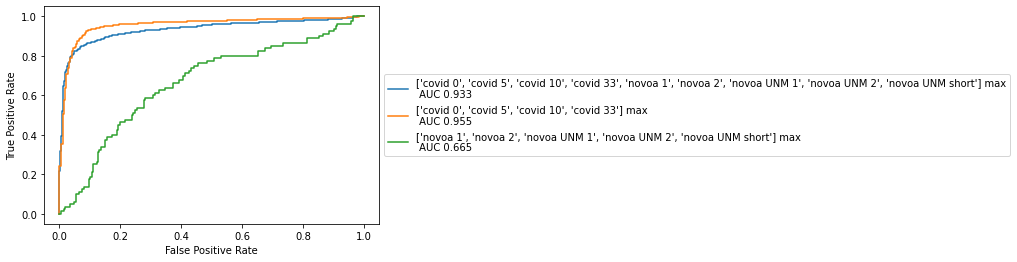

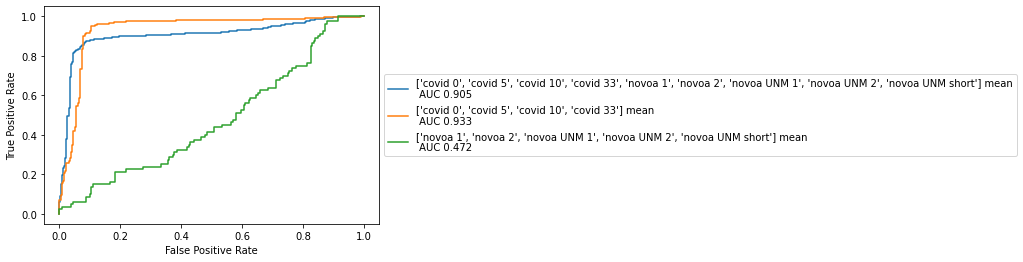

In [16]:
plot_roc_curves(dsets_preds)